In [2]:
!pip install sklearn

     |████████████████████████████████| 6.8 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 298 kB 20.3 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=ff9b1ed56a543244f19936712a0d461a4cee70ecfc6bdf4c4b84bb3817d62975
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras
import gc
from sys import getsizeof
import datetime
import random
import math
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
GB = 1
gpus = tf.config.experimental.list_physical_devices('GPU')
#The variable GB is the memory size you want to use.
config = [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*GB))]
if gpus:
  # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], config)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
np.set_printoptions(threshold=40*40)


In [26]:
def load_data(res, source_labels, dataset='train', size=1., verbosity = False):
    data = np.zeros((0, res, res, res))
    labels = []
    for i, label in enumerate(source_labels):
        filename = './output/' + label + '/output-' + dataset + '-' + str(res) + '.h5'
        file = h5py.File(filename, 'r')
        tensor_len = len(file['tensor'])
        picked_ids = random.sample(range(tensor_len), math.ceil(tensor_len * size))
        if verbosity:
            print(filename)
            print('Picking ' + str(math.ceil(tensor_len * size)) + ' from ' + str(len(file['tensor'])) )
        data = np.concatenate((data, [file['tensor'][index] for index in picked_ids]))
        labels = np.concatenate((labels, np.full(len(picked_ids), i)))
        file.close()
        gc.collect()
    rng_state = np.random.get_state()
    np.random.shuffle(data)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    return (data, labels)


In [18]:
def prepare_model(res, num_classes, verbosity = 0):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(res, res, res)),
        keras.layers.Dense(res*2, activation='relu'),
        keras.layers.Dense(res/2, activation='sigmoid'),
        keras.layers.Dropout(.2, input_shape=(2,)),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    learning_rate = 0.0001

    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    if (verbosity == 1):
        print(model.summary())
    return model
def prepare_data(data, num_classes):
    return data
model_type = 'dense'
prepare_model(24, 20, 1)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 13824)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 48)                663600    
_________________________________________________________________
dense_49 (Dense)             (None, 12)                588       
_________________________________________________________________
dropout_16 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 20)                260       
Total params: 664,448
Trainable params: 664,448
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
def prepare_model(res, num_classes, verbosity = 0):
    model = keras.Sequential([
        keras.layers.Conv3D(
                res, 
                kernel_size=(3), 
                activation='relu', 
                kernel_initializer='he_uniform', 
                data_format="channels_last",
                input_shape=(res, res, res, num_classes)
            ),        
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(res/2, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    learning_rate = 0.0001

    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    if (verbosity == 1):
        print(model.summary())
    return model
def prepare_data(data, num_classes):
    return keras.utils.to_categorical(data, num_classes)
model_type = 'conv3d'
prepare_model(24, 10, 1)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 22, 22, 22, 24)    6504      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 11, 11, 11, 24)    0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 31944)             0         
_________________________________________________________________
dense_78 (Dense)             (None, 12)                383340    
_________________________________________________________________
dense_79 (Dense)             (None, 10)                130       
Total params: 389,974
Trainable params: 389,974
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
def train(model, training, training_labels, res, num_classes, verbosity = 0):
    log_dir = "logs/fit/" + str(res) + '-' + str(num_classes) + '-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if verbosity == 1:
        print("Log file " + log_dir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    validation_split = 0.1
    epochs = 10 * num_classes
    
#    model.fit(
#        keras.utils.to_categorical(training, num_clases), 
#        training_labels, 
#        epochs=epochs)
    
    model.fit(
        prepare_data(training, num_classes), 
        training_labels, 
        epochs=epochs,
        verbose=verbosity,
        callbacks=[tensorboard_callback],
        validation_split=validation_split
    )

In [7]:
#Confusion Matrix and Classification Report
def print_confusion_matrix(test, test_labels, base_labels):
    Y_pred = model.predict_generator(prepare_data(test, len(base_labels)), len(test))
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(test_labels, y_pred))
    print('Classification Report')
    print(classification_report(test_labels, y_pred, target_names=base_labels))

In [8]:
#base_labels = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
all_labels = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 
                 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar','keyboard', 'lamp',
                 'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 
                 'radio', 'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 
                 'vase', 'wardrobe', 'xbox']
#num_classes = len(base_labels)

In [28]:
subclases = [20, 30, 40]
resolutions = [24]#, 32]#, 48]

for j, num_classes in enumerate(subclases):
    base_labels = all_labels[:num_classes]
    for i,res in enumerate(resolutions):
        training, training_labels = load_data(res, base_labels, 'train', 1, False)
        model = prepare_model(res, num_classes, 1)
        model_name = 'models/' + model_type + '-' + str(num_classes) + '-' + str(res) + '.h5'
        train(model, training, training_labels, res, num_classes, 2)
        model.save(model_name)
        test, test_labels = load_data(res, base_labels, 'test', 1.0, False)
        test_loss, test_acc = model.evaluate(
            prepare_data(test, num_classes),  
            test_labels, 
            verbose=2
        )
        print('\nTest accuracy for ' + str(num_classes) + ' classes width res ' + str(res) + ':', test_acc)
        print_confusion_matrix(test, test_labels, base_labels)
        gc.collect()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 13824)             0         
_________________________________________________________________
dense_69 (Dense)             (None, 48)                663600    
_________________________________________________________________
dense_70 (Dense)             (None, 12)                588       
_________________________________________________________________
dropout_23 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 20)                260       
Total params: 664,448
Trainable params: 664,448
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
144/144 - 1s - loss: 2.7847 - accuracy: 0.2030 - val_loss: 2.5597 - val_accuracy: 0.4473
Epoch 2

Epoch 72/200
144/144 - 1s - loss: 0.7502 - accuracy: 0.8381 - val_loss: 0.7826 - val_accuracy: 0.8418
Epoch 73/200
144/144 - 1s - loss: 0.7357 - accuracy: 0.8477 - val_loss: 0.7797 - val_accuracy: 0.8418
Epoch 74/200
144/144 - 1s - loss: 0.7247 - accuracy: 0.8403 - val_loss: 0.7760 - val_accuracy: 0.8359
Epoch 75/200
144/144 - 1s - loss: 0.7310 - accuracy: 0.8362 - val_loss: 0.7701 - val_accuracy: 0.8398
Epoch 76/200
144/144 - 1s - loss: 0.7167 - accuracy: 0.8416 - val_loss: 0.7663 - val_accuracy: 0.8398
Epoch 77/200
144/144 - 1s - loss: 0.7009 - accuracy: 0.8468 - val_loss: 0.7590 - val_accuracy: 0.8418
Epoch 78/200
144/144 - 1s - loss: 0.6874 - accuracy: 0.8531 - val_loss: 0.7530 - val_accuracy: 0.8398
Epoch 79/200
144/144 - 1s - loss: 0.6982 - accuracy: 0.8462 - val_loss: 0.7489 - val_accuracy: 0.8457
Epoch 80/200
144/144 - 1s - loss: 0.6853 - accuracy: 0.8529 - val_loss: 0.7489 - val_accuracy: 0.8438
Epoch 81/200
144/144 - 1s - loss: 0.6825 - accuracy: 0.8446 - val_loss: 0.7443 - v

Epoch 152/200
144/144 - 1s - loss: 0.4166 - accuracy: 0.8953 - val_loss: 0.6020 - val_accuracy: 0.8496
Epoch 153/200
144/144 - 1s - loss: 0.4193 - accuracy: 0.8948 - val_loss: 0.6062 - val_accuracy: 0.8438
Epoch 154/200
144/144 - 1s - loss: 0.4241 - accuracy: 0.8957 - val_loss: 0.6043 - val_accuracy: 0.8496
Epoch 155/200
144/144 - 1s - loss: 0.4175 - accuracy: 0.8927 - val_loss: 0.6030 - val_accuracy: 0.8457
Epoch 156/200
144/144 - 1s - loss: 0.4162 - accuracy: 0.8972 - val_loss: 0.6004 - val_accuracy: 0.8535
Epoch 157/200
144/144 - 1s - loss: 0.4095 - accuracy: 0.8963 - val_loss: 0.6019 - val_accuracy: 0.8555
Epoch 158/200
144/144 - 1s - loss: 0.4182 - accuracy: 0.8953 - val_loss: 0.6005 - val_accuracy: 0.8574
Epoch 159/200
144/144 - 1s - loss: 0.4050 - accuracy: 0.9016 - val_loss: 0.5984 - val_accuracy: 0.8535
Epoch 160/200
144/144 - 1s - loss: 0.4120 - accuracy: 0.8992 - val_loss: 0.6038 - val_accuracy: 0.8496
Epoch 161/200
144/144 - 1s - loss: 0.4139 - accuracy: 0.8933 - val_loss: 

Epoch 1/300
201/201 - 1s - loss: 3.2588 - accuracy: 0.1357 - val_loss: 3.0880 - val_accuracy: 0.2879
Epoch 2/300
201/201 - 1s - loss: 3.0232 - accuracy: 0.2654 - val_loss: 2.9428 - val_accuracy: 0.3610
Epoch 3/300
201/201 - 1s - loss: 2.8987 - accuracy: 0.3238 - val_loss: 2.8404 - val_accuracy: 0.4073
Epoch 4/300
201/201 - 1s - loss: 2.8067 - accuracy: 0.3626 - val_loss: 2.7533 - val_accuracy: 0.4494
Epoch 5/300
201/201 - 1s - loss: 2.7251 - accuracy: 0.4193 - val_loss: 2.6758 - val_accuracy: 0.5098
Epoch 6/300
201/201 - 1s - loss: 2.6472 - accuracy: 0.4532 - val_loss: 2.6038 - val_accuracy: 0.5379
Epoch 7/300
201/201 - 1s - loss: 2.5675 - accuracy: 0.4811 - val_loss: 2.5345 - val_accuracy: 0.5435
Epoch 8/300
201/201 - 1s - loss: 2.4992 - accuracy: 0.4934 - val_loss: 2.4692 - val_accuracy: 0.5506
Epoch 9/300
201/201 - 1s - loss: 2.4365 - accuracy: 0.4998 - val_loss: 2.4063 - val_accuracy: 0.5548
Epoch 10/300
201/201 - 1s - loss: 2.3824 - accuracy: 0.5045 - val_loss: 2.3503 - val_accura

Epoch 82/300
201/201 - 1s - loss: 0.9157 - accuracy: 0.7752 - val_loss: 1.0868 - val_accuracy: 0.7514
Epoch 83/300
201/201 - 1s - loss: 0.9135 - accuracy: 0.7783 - val_loss: 1.0863 - val_accuracy: 0.7486
Epoch 84/300
201/201 - 1s - loss: 0.8984 - accuracy: 0.7810 - val_loss: 1.0743 - val_accuracy: 0.7570
Epoch 85/300
201/201 - 1s - loss: 0.8921 - accuracy: 0.7835 - val_loss: 1.0729 - val_accuracy: 0.7542
Epoch 86/300
201/201 - 1s - loss: 0.8764 - accuracy: 0.7932 - val_loss: 1.0635 - val_accuracy: 0.7542
Epoch 87/300
201/201 - 1s - loss: 0.8796 - accuracy: 0.7854 - val_loss: 1.0604 - val_accuracy: 0.7584
Epoch 88/300
201/201 - 1s - loss: 0.8663 - accuracy: 0.7882 - val_loss: 1.0608 - val_accuracy: 0.7514
Epoch 89/300
201/201 - 1s - loss: 0.8730 - accuracy: 0.7872 - val_loss: 1.0544 - val_accuracy: 0.7528
Epoch 90/300
201/201 - 1s - loss: 0.8651 - accuracy: 0.7897 - val_loss: 1.0502 - val_accuracy: 0.7570
Epoch 91/300
201/201 - 1s - loss: 0.8519 - accuracy: 0.7930 - val_loss: 1.0463 - v

Epoch 162/300
201/201 - 1s - loss: 0.5774 - accuracy: 0.8506 - val_loss: 0.9398 - val_accuracy: 0.7725
Epoch 163/300
201/201 - 1s - loss: 0.5793 - accuracy: 0.8522 - val_loss: 0.9372 - val_accuracy: 0.7725
Epoch 164/300
201/201 - 1s - loss: 0.5743 - accuracy: 0.8526 - val_loss: 0.9407 - val_accuracy: 0.7640
Epoch 165/300
201/201 - 1s - loss: 0.5857 - accuracy: 0.8492 - val_loss: 0.9426 - val_accuracy: 0.7697
Epoch 166/300
201/201 - 1s - loss: 0.5806 - accuracy: 0.8494 - val_loss: 0.9421 - val_accuracy: 0.7753
Epoch 167/300
201/201 - 1s - loss: 0.5850 - accuracy: 0.8515 - val_loss: 0.9374 - val_accuracy: 0.7781
Epoch 168/300
201/201 - 1s - loss: 0.5767 - accuracy: 0.8494 - val_loss: 0.9320 - val_accuracy: 0.7725
Epoch 169/300
201/201 - 1s - loss: 0.5762 - accuracy: 0.8519 - val_loss: 0.9346 - val_accuracy: 0.7669
Epoch 170/300
201/201 - 1s - loss: 0.5618 - accuracy: 0.8547 - val_loss: 0.9384 - val_accuracy: 0.7683
Epoch 171/300
201/201 - 1s - loss: 0.5588 - accuracy: 0.8542 - val_loss: 

Epoch 242/300
201/201 - 1s - loss: 0.4762 - accuracy: 0.8676 - val_loss: 0.9876 - val_accuracy: 0.7584
Epoch 243/300
201/201 - 1s - loss: 0.4692 - accuracy: 0.8707 - val_loss: 0.9800 - val_accuracy: 0.7542
Epoch 244/300
201/201 - 1s - loss: 0.4788 - accuracy: 0.8697 - val_loss: 0.9766 - val_accuracy: 0.7612
Epoch 245/300
201/201 - 1s - loss: 0.4808 - accuracy: 0.8629 - val_loss: 0.9800 - val_accuracy: 0.7584
Epoch 246/300
201/201 - 1s - loss: 0.4735 - accuracy: 0.8695 - val_loss: 0.9795 - val_accuracy: 0.7570
Epoch 247/300
201/201 - 1s - loss: 0.4733 - accuracy: 0.8722 - val_loss: 0.9861 - val_accuracy: 0.7584
Epoch 248/300
201/201 - 1s - loss: 0.4748 - accuracy: 0.8667 - val_loss: 0.9938 - val_accuracy: 0.7542
Epoch 249/300
201/201 - 1s - loss: 0.4824 - accuracy: 0.8617 - val_loss: 0.9866 - val_accuracy: 0.7584
Epoch 250/300
201/201 - 1s - loss: 0.4796 - accuracy: 0.8687 - val_loss: 0.9857 - val_accuracy: 0.7584
Epoch 251/300
201/201 - 1s - loss: 0.4675 - accuracy: 0.8712 - val_loss: 

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_25 (Flatten)         (None, 13824)             0         
_________________________________________________________________
dense_75 (Dense)             (None, 48)                663600    
_________________________________________________________________
dense_76 (Dense)             (None, 12)                588       
_________________________________________________________________
dropout_25 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 40)                520       
Total params: 664,708
Trainable params: 664,708
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/400
277/277 - 2s - loss: 3.4980 - accuracy: 0.1184 - val_loss: 3.3395 - val_accuracy: 0.2173
Epoch 2

Epoch 72/400
277/277 - 2s - loss: 1.1992 - accuracy: 0.6959 - val_loss: 1.4131 - val_accuracy: 0.6802
Epoch 73/400
277/277 - 2s - loss: 1.1899 - accuracy: 0.6955 - val_loss: 1.4012 - val_accuracy: 0.6883
Epoch 74/400
277/277 - 2s - loss: 1.1939 - accuracy: 0.6942 - val_loss: 1.4017 - val_accuracy: 0.6853
Epoch 75/400
277/277 - 2s - loss: 1.1745 - accuracy: 0.7000 - val_loss: 1.3905 - val_accuracy: 0.6832
Epoch 76/400
277/277 - 2s - loss: 1.1639 - accuracy: 0.7049 - val_loss: 1.3903 - val_accuracy: 0.6812
Epoch 77/400
277/277 - 2s - loss: 1.1617 - accuracy: 0.7049 - val_loss: 1.3843 - val_accuracy: 0.6812
Epoch 78/400
277/277 - 2s - loss: 1.1397 - accuracy: 0.7118 - val_loss: 1.3787 - val_accuracy: 0.6863
Epoch 79/400
277/277 - 2s - loss: 1.1427 - accuracy: 0.7108 - val_loss: 1.3681 - val_accuracy: 0.6863
Epoch 80/400
277/277 - 2s - loss: 1.1273 - accuracy: 0.7136 - val_loss: 1.3679 - val_accuracy: 0.6802
Epoch 81/400
277/277 - 2s - loss: 1.1236 - accuracy: 0.7118 - val_loss: 1.3614 - v

Epoch 152/400
277/277 - 2s - loss: 0.8006 - accuracy: 0.7891 - val_loss: 1.2451 - val_accuracy: 0.6964
Epoch 153/400
277/277 - 2s - loss: 0.7896 - accuracy: 0.7922 - val_loss: 1.2355 - val_accuracy: 0.6975
Epoch 154/400
277/277 - 2s - loss: 0.7972 - accuracy: 0.7822 - val_loss: 1.2487 - val_accuracy: 0.7015
Epoch 155/400
277/277 - 2s - loss: 0.7727 - accuracy: 0.8002 - val_loss: 1.2508 - val_accuracy: 0.7015
Epoch 156/400
277/277 - 2s - loss: 0.7783 - accuracy: 0.7945 - val_loss: 1.2341 - val_accuracy: 0.7046
Epoch 157/400
277/277 - 2s - loss: 0.7836 - accuracy: 0.7926 - val_loss: 1.2412 - val_accuracy: 0.6995
Epoch 158/400
277/277 - 2s - loss: 0.7690 - accuracy: 0.7969 - val_loss: 1.2413 - val_accuracy: 0.6995
Epoch 159/400
277/277 - 2s - loss: 0.7797 - accuracy: 0.7954 - val_loss: 1.2387 - val_accuracy: 0.7056
Epoch 160/400
277/277 - 2s - loss: 0.7758 - accuracy: 0.7980 - val_loss: 1.2482 - val_accuracy: 0.7056
Epoch 161/400
277/277 - 2s - loss: 0.7664 - accuracy: 0.8011 - val_loss: 

Epoch 232/400
277/277 - 2s - loss: 0.6533 - accuracy: 0.8155 - val_loss: 1.3005 - val_accuracy: 0.7066
Epoch 233/400
277/277 - 2s - loss: 0.6407 - accuracy: 0.8198 - val_loss: 1.3147 - val_accuracy: 0.7025
Epoch 234/400
277/277 - 2s - loss: 0.6493 - accuracy: 0.8222 - val_loss: 1.3156 - val_accuracy: 0.7036
Epoch 235/400
277/277 - 2s - loss: 0.6427 - accuracy: 0.8250 - val_loss: 1.3020 - val_accuracy: 0.6985
Epoch 236/400
277/277 - 2s - loss: 0.6369 - accuracy: 0.8221 - val_loss: 1.3102 - val_accuracy: 0.7036
Epoch 237/400
277/277 - 2s - loss: 0.6358 - accuracy: 0.8241 - val_loss: 1.3222 - val_accuracy: 0.6975
Epoch 238/400
277/277 - 2s - loss: 0.6395 - accuracy: 0.8252 - val_loss: 1.3235 - val_accuracy: 0.6985
Epoch 239/400
277/277 - 2s - loss: 0.6413 - accuracy: 0.8220 - val_loss: 1.3274 - val_accuracy: 0.7005
Epoch 240/400
277/277 - 2s - loss: 0.6430 - accuracy: 0.8251 - val_loss: 1.3193 - val_accuracy: 0.7015
Epoch 241/400
277/277 - 2s - loss: 0.6400 - accuracy: 0.8246 - val_loss: 

Epoch 312/400
277/277 - 2s - loss: 0.5750 - accuracy: 0.8363 - val_loss: 1.3786 - val_accuracy: 0.7005
Epoch 313/400
277/277 - 2s - loss: 0.5924 - accuracy: 0.8268 - val_loss: 1.3836 - val_accuracy: 0.7015
Epoch 314/400
277/277 - 2s - loss: 0.5694 - accuracy: 0.8386 - val_loss: 1.3858 - val_accuracy: 0.6995
Epoch 315/400
277/277 - 2s - loss: 0.5801 - accuracy: 0.8364 - val_loss: 1.3880 - val_accuracy: 0.6995
Epoch 316/400
277/277 - 2s - loss: 0.5705 - accuracy: 0.8379 - val_loss: 1.3857 - val_accuracy: 0.7015
Epoch 317/400
277/277 - 2s - loss: 0.5701 - accuracy: 0.8395 - val_loss: 1.3843 - val_accuracy: 0.7025
Epoch 318/400
277/277 - 2s - loss: 0.5625 - accuracy: 0.8380 - val_loss: 1.3935 - val_accuracy: 0.6964
Epoch 319/400
277/277 - 2s - loss: 0.5698 - accuracy: 0.8359 - val_loss: 1.3841 - val_accuracy: 0.6944
Epoch 320/400
277/277 - 2s - loss: 0.5751 - accuracy: 0.8331 - val_loss: 1.3943 - val_accuracy: 0.6944
Epoch 321/400
277/277 - 2s - loss: 0.5805 - accuracy: 0.8347 - val_loss: 

Epoch 392/400
277/277 - 2s - loss: 0.5446 - accuracy: 0.8434 - val_loss: 1.4626 - val_accuracy: 0.7025
Epoch 393/400
277/277 - 2s - loss: 0.5260 - accuracy: 0.8455 - val_loss: 1.4777 - val_accuracy: 0.6914
Epoch 394/400
277/277 - 2s - loss: 0.5341 - accuracy: 0.8433 - val_loss: 1.4709 - val_accuracy: 0.6944
Epoch 395/400
277/277 - 2s - loss: 0.5436 - accuracy: 0.8450 - val_loss: 1.4686 - val_accuracy: 0.6934
Epoch 396/400
277/277 - 2s - loss: 0.5490 - accuracy: 0.8398 - val_loss: 1.4718 - val_accuracy: 0.6954
Epoch 397/400
277/277 - 2s - loss: 0.5521 - accuracy: 0.8395 - val_loss: 1.4688 - val_accuracy: 0.6954
Epoch 398/400
277/277 - 2s - loss: 0.5466 - accuracy: 0.8388 - val_loss: 1.4717 - val_accuracy: 0.6914
Epoch 399/400
277/277 - 2s - loss: 0.5401 - accuracy: 0.8379 - val_loss: 1.4801 - val_accuracy: 0.6893
Epoch 400/400
277/277 - 2s - loss: 0.5380 - accuracy: 0.8429 - val_loss: 1.4783 - val_accuracy: 0.6944
78/78 - 0s - loss: 1.5728 - accuracy: 0.6613

Test accuracy for 40 classe

In [8]:
model = keras.models.load_model('models/dense-20-24')


In [11]:
num_classes = 20
res = 24
base_labels = all_labels[:num_classes]
test, test_labels = load_data(res, base_labels, 'test', 1.0, False)


In [12]:
test_loss, test_acc = model.evaluate(
            prepare_data(test, num_classes),  
            test_labels, 
            verbose=2
        )
print('\nTest accuracy for ' + str(num_classes) + ' classes width res ' + str(res) + ':', test_acc)
print_confusion_matrix(test, test_labels, base_labels)

38/38 - 0s - loss: 0.6880 - accuracy: 0.8295

Test accuracy for 20 classes width res 24: 0.8294509053230286
Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[94  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0]
 [ 1 37  8  1  0  0  1  1  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  1 93  0  0  0  0  0  3  0  0  0  0  0  0  0  1  0  2  0]
 [ 0  0  0 14  1  0  0  1  2  0  0  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0 88  3  0  0  1  0  0  3  0  3  0  0  1  0  0  1]
 [ 0  0  0  1  1 72  0  0  1  5  1  0  0  0  1  2  0  4  0 12]
 [ 0  0  0  0  0  0 12  2  2  0  0  0  0  0  0  0  0  2  2  0]
 [ 4  0  2  1  0  1  0 83  5  0  0  1  0  0  0  0  3  0  0  0]
 [ 0  0  6  1  1  1  0  0 89  0  0  0  0  0  0  0  0  1  0  1]
 [ 0  0  1  0  2  1  0  0  0 14  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  0  0  1  0  2  0  2  0  6  0  0  0  0  8  0  1  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0 14  0  4  0  0  1  0  0  0]
 [ 0  0  2  0  2  0  0  0  0  0  0  0 7

In [61]:
def draw(img, expected = '', predicted = ''):
    fig = plt.figure(figsize=[10,10])
    ax = fig.gca(projection='3d')
    cube1 = (img[:,:,:] >= 1)
    ax.voxels(cube1, facecolors="blue")
    plt.title('Expected: {}\n Predicted: {}'.format(expected, predicted), y=-0.01)
    plt.show()

In [44]:
if not len(test):
    test, test_labels = load_data(dim, base_labels, 'test', 100)
test_loss, test_acc = model.evaluate(test,  test_labels, verbose=2)
p = model.predict(test)
print('\nTest accuracy:', test_acc)

78/78 - 0s - loss: 1.5728 - accuracy: 0.6613

Test accuracy: 0.661264181137085


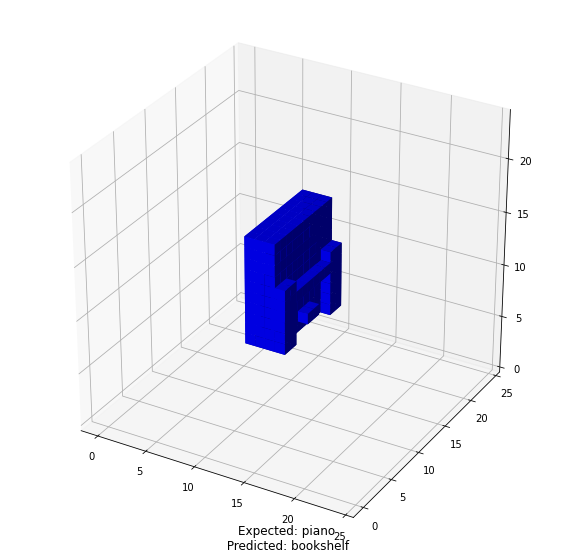

816

In [64]:
index = random.randint(0, len(test))

predicted_index = np.argmax(p[index])
expected = base_labels[int(test_labels[index])]
predicted = base_labels[predicted_index]
draw(test[index], expected, predicted)
index

In [ ]:
num_classes = 3
base_labels = all_labels[:num_classes]
num_classes = num_classes
res = 24
training, training_labels = load_data(res, base_labels, 'train', 1, True)


In [ ]:
print(len(training))
model = prepare_model(res, num_classes, 1)
train(model, training, training_labels, res, num_classes, 0)


In [ ]:
print(base_labels)
test, test_labels = load_data(res, base_labels, 'test', 1.0, True)
print(len(test))
test_loss, test_acc = model.evaluate(
    test,  
    test_labels, 
    verbose=2
)


In [ ]:
p = model.predict(test)
for index in range(len(p)):
    predicted_index = np.argmax(p[index])
    expected = base_labels[int(test_labels[index])]
    predicted = base_labels[predicted_index]
    if expected != predicted:
        draw(test[index], expected, predicted)
